In [ ]:
#Set the file path to execute the notebook on kaggle
file_path = "/kaggle/input/mars-cleaned/mars_cleaned_dataset.npz"



This notebook is supposed to be runned on Kaggle



# Import necessary libraries

In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import json
import datetime
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

#import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


2.16.1


#Import the dataset and turn np arrays in tensorflow datasets

In [ ]:
# Loading the cleaned dataset
data = np.load(file_path)
X = data["X_train"]
y = data["y_train"]
X_final_test = data["X_test"]
#Check images and labels shape
print(X.shape)
print(y.shape)
print(X_final_test.shape)
#Splitting
val_size = 0.15
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=val_size, random_state=seed)
#Turning np dataset in tf dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
final_test_dataset = tf.data.Dataset.from_tensor_slices(X_final_test)


(2505, 64, 128)
(2505, 64, 128)
(10022, 64, 128)


#Tile images and segmentations in two 64x64 images / segmentation masks

In [ ]:
#Tiling functin
def tile_dataset(dataset, image_shape, label_shape):
    """
    Tiles each image and segmentation label in the dataset into two halves along the width.

    Args:
    - dataset (tf.data.Dataset): A dataset of (image, label) pairs.
    - image_shape (tuple): The shape of each image (height, width, channels).
    - label_shape (tuple): The shape of each segmentation label (height, width, channels).

    Returns:
    - tf.data.Dataset: A new dataset with tiled images and labels.
    """
    def tile_image_label(image, label):
        # Split the image and label along the width (axis=1)
        image_tile1, image_tile2 = tf.split(image, num_or_size_splits=2, axis=1)
        label_tile1, label_tile2 = tf.split(label, num_or_size_splits=2, axis=1)

        # Combine the tiles into two new (image, label) pairs
        tiled1 = (image_tile1, label_tile1)
        tiled2 = (image_tile2, label_tile2)
        return tf.data.Dataset.from_tensors(tiled1).concatenate(tf.data.Dataset.from_tensors(tiled2))

    # Map the tile operation over the dataset
    tiled_dataset = dataset.flat_map(lambda image, label: tile_image_label(image, label))

    return tiled_dataset

#Tiling
train_dataset = tile_dataset(train_dataset, (64, 64, 1), (64, 64, 1))
val_dataset = tile_dataset(val_dataset, (64, 64, 1), (64, 64, 1))



#Define the segmentation loss

In [ ]:
class MaskedSparseCategoricalCrossentropy(tf.keras.losses.SparseCategoricalCrossentropy):
    def __init__(self, labels_to_exclude=None, from_logits=False, name="masked_sparse_categorical_crossentropy"):
        """
        Custom SparseCategoricalCrossentropy to exclude specific labels from the loss calculation.

        Args:
            labels_to_exclude: List of labels to exclude from the loss calculation (e.g., [0]).
            from_logits: Whether y_pred is logits (default: False).
            name: Name of the loss function.
        """
        super().__init__(from_logits=from_logits, reduction=tf.keras.losses.Reduction.NONE, name=name)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def call(self, y_true, y_pred):
        """
        Compute the sparse categorical cross-entropy loss, excluding specific labels.

        Args:
            y_true: Ground truth labels, tensor of shape (batch_size, height, width).
            y_pred: Prediloss_fn = MaskedSparseCategoricalCrossentropy(labels_to_exclude=[0], from_logits=True)cted logits or probabilities, tensor of shape (batch_size, height, width, num_classes).

        Returns:
            Scalar loss value excluding contributions from specified labels.
        """
        # Flatten y_true and y_pred for easier masking
        y_true = tf.reshape(y_true, [-1])  # Shape: (batch_size * height * width,)
        y_pred = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])  # Shape: (batch_size * height * width, num_classes)

        # Create a mask to exclude specified labels
        mask = tf.ones_like(y_true, dtype=tf.bool)  # Start with all True
        for label in self.labels_to_exclude:
            mask = mask & tf.not_equal(y_true, label)  # Exclude label(s)

        # Apply the mask to y_true and y_pred
        y_true = tf.boolean_mask(y_true, mask)  # Remove excluded labels
        y_pred = tf.boolean_mask(y_pred, mask)  # Keep only valid predictions

        # Compute the sparse categorical cross-entropy loss
        per_pixel_loss = super().call(y_true, y_pred)  # Uses parent class implementation

        # Average the loss across all valid pixels
        return tf.reduce_mean(per_pixel_loss)


#Selection of data preprocessing and model hyperparameters

In [ ]:
#Augmentation, applied to train and validation
augment_geometrical = True
augment_noise = False
augment_texture = True
#Balancing technique
balance = True #if true the rock class is oversampled based on rock_overaampling
rock_oversampling = 2 #values in [1,n]. 1 means no oversampling
#Model complexity parameters
STACK = 2 #the unet block stack
#training parameters
BATCH_SIZE = 64
INPUT_SHAPE = (64, 64, 1)
NUM_CLASSES = 5
LEARNING_RATE = 2e-4
EPOCHS = 25
PATIENCE = 5
OPTIMIZER = tf.keras.optimizers.AdamW(LEARNING_RATE)
#Model training loss
loss = MaskedSparseCategoricalCrossentropy(labels_to_exclude=[0])

#Minority class (rock) oversampling


In [ ]:
def rock_oversample(dataset, oversampling_ratio=1):
    """
    Oversample elements in the dataset where the label contains the class 'Big Rock' (class label 4).

    Parameters:
    dataset: tf.data.Dataset - The input dataset containing (image, label) pairs
    oversampling_ratio: int - The number of times to duplicate elements with 'Big Rock'

    Returns:
    tf.data.Dataset - The oversampled dataset
    """
    def contains_big_rock(image, label):
        """
        Check if the label contains the undersampled class 'Big Rock' (class label 4).
        """
        return tf.reduce_any(label == 4)

    def oversample_fn(image, label):
        """
        Duplicate the (image, label) pair if it contains 'Big Rock'.
        """
        # If contains 'Big Rock', repeat the element 'oversampling_ratio' times
        return tf.cond(
            contains_big_rock(image, label),
            lambda: tf.data.Dataset.from_tensors((image, label)).repeat(oversampling_ratio),
            lambda: tf.data.Dataset.from_tensors((image, label))
        )

    # Apply the oversampling logic to each element using flat_map
    oversampled_dataset = dataset.flat_map(oversample_fn)

    # Shuffle the oversampled dataset to mix the duplicates with the original data
    oversampled_dataset = oversampled_dataset.shuffle(buffer_size=1000)

    return oversampled_dataset

if balance:
  # training oversample
  print("Oversampling dataset...")
  train_dataset = rock_oversample(
      dataset=train_dataset,
      oversampling_ratio=rock_oversampling
  )

Oversampling dataset...


#Print validation and training dataset shapes


In [ ]:
for image, label in train_dataset.take(1):  # Take one batch to inspect the shape
    print(f"Image shape: {image.shape}")
    print(f"Label shape: {label.shape}")

# To get the number of elements in the dataset
num_images = sum(1 for _ in train_dataset)
print(f"Number of images in the train dataset: {num_images}")

for image, label in val_dataset.take(1):  # Take one batch to inspect the shape
    print(f"Image shape: {image.shape}")
    print(f"Label shape: {label.shape}")

# To get the number of elements in the dataset
num_images = sum(1 for _ in val_dataset)
print(f"Number of images in the val dataset: {num_images}")




Image shape: (64, 64)
Label shape: (64, 64)
Number of images in the train dataset: 4344
Image shape: (64, 64)
Label shape: (64, 64)
Number of images in the val dataset: 752


# Define augmentations and perform augmentations on the dataset

In [ ]:
import tensorflow as tf
#import tensorflow_addons as tfa
import numpy as np

# Define augmentation functions

@tf.function
def random_flip(image, label, seed=None):
    """Consistently applies random horizontal flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)


    # Ensure image and label have a channel dimension
    image = tf.expand_dims(image, axis=-1)
    label = tf.expand_dims(label, axis=-1)

    image = tf.image.flip_left_right(image)
    label = tf.image.flip_left_right(label)

    # Remove the channel dimension
    image = tf.squeeze(image, axis=-1)
    label = tf.squeeze(label, axis=-1)

    return image, label


@tf.function
def random_vertical_flip(image, label, seed=None):
    """Consistently applies random vertical flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)


    # Ensure image and label have a channel dimension
    image = tf.expand_dims(image, axis=-1)
    label = tf.expand_dims(label, axis=-1)

    image = tf.image.flip_up_down(image)
    label = tf.image.flip_up_down(label)

    # Remove the channel dimension
    image = tf.squeeze(image, axis=-1)
    label = tf.squeeze(label, axis=-1)

    return image, label


import tensorflow as tf

@tf.function
def random_rescale(image, label, min_scale=1, max_scale=1.4, seed=None):

    if seed is not None:
        tf.random.set_seed(seed)

    # Add a channel dimension
    image = tf.expand_dims(image, axis=-1)
    label = tf.expand_dims(label, axis=-1)

    # Get the original image size
    original_height, original_width = tf.shape(image)[0], tf.shape(image)[1]

    # Generate a random scaling factor
    scale = tf.random.uniform([], minval=min_scale, maxval=max_scale, seed=seed)

    # Compute the new dimensions
    new_height = tf.cast(scale * tf.cast(original_height, tf.float32), tf.int32)
    new_width = tf.cast(scale * tf.cast(original_width, tf.float32), tf.int32)

    # Resize the image and label
    image_resized = tf.image.resize(image, [new_height, new_width], method='bilinear')
    label_resized = tf.image.resize(label, [new_height, new_width], method='nearest')  # Nearest neighbor for labels

    # Crop back to the original size (center crop)
    image_rescaled = tf.image.resize_with_crop_or_pad(image_resized, original_height, original_width)
    label_rescaled = tf.image.resize_with_crop_or_pad(label_resized, original_height, original_width)
    #rebring to 2d image
    # Add a channel dimension
    image_rescaled = tf.squeeze(image_rescaled, axis=-1)
    label_rescaled = tf.squeeze(label_rescaled, axis=-1)

    return image_rescaled, label_rescaled

def random_rotation(image, label, max_angle=30, seed=None):
    if seed is None:
        seed = np.random.randint(0, 1000000)

    # Generate a random angle in degrees
    angle = tf.random.uniform([], minval=-max_angle, maxval=max_angle, seed=seed)
    angle_rad = angle * (3.14159265359 / 180)  # Convert degrees to radians

    # Add a channel dimension if the image is 2D
    if len(image.shape) == 2:
        image = tf.expand_dims(image, axis=-1)
        label = tf.expand_dims(label, axis=-1)

    # Rotate image and label
    image_rotated = tf.image.rot90(image, k=tf.cast(angle_rad // 90, tf.int32))
    label_rotated = tf.image.rot90(label, k=tf.cast(angle_rad // 90, tf.int32))

    # Remove the channel dimension if it was added
    if len(image.shape) == 3 and image.shape[-1] == 1:
        image_rotated = tf.squeeze(image_rotated, axis=-1)
        label_rotated = tf.squeeze(label_rotated, axis=-1)

    return image_rotated, label_rotated


@tf.function
def random_gaussian_noise(image, label, mean=0.0, stddev=1.0, seed=None):
    if seed is None:
        seed = np.random.randint(0, 1000000)

    # Ensure image is one-channel and in float32 for noise addition
    image = tf.cast(image, tf.float32)

    # Generate Gaussian noise with the same shape as the image
    noise = tf.random.normal(shape=tf.shape(image), mean=mean, stddev=stddev, seed=seed)

    # Add noise to the image
    noisy_image = image + noise

    # Clip values to maintain valid range [0, 255]
    noisy_image = tf.clip_by_value(noisy_image, 0.0, 255.0)

    # Cast the noisy image to float64 (64-bit)
    noisy_image = tf.cast(noisy_image, tf.float64)

    return noisy_image, label




@tf.function
def random_brightness(image, label, max_delta=30, seed=None):
    """Adjusts the brightness of the image by a random factor."""
    if seed is not None:
        tf.random.set_seed(seed)

    adjusted_image = tf.image.random_brightness(image, max_delta=max_delta)
    adjusted_image = tf.clip_by_value(adjusted_image, 0.0, 255.0)

    return adjusted_image, label


@tf.function
def random_contrast(image, label, lower=0.5, upper=1.5, seed=None):
    """Adjusts the contrast of the image by a random factor."""
    if seed is not None:
        tf.random.set_seed(seed)

    # Add a channel dimension
    image = tf.expand_dims(image, axis=-1)
    contrast_factor = tf.random.uniform([], lower, upper)
    adjusted_image = tf.image.adjust_contrast(image, contrast_factor)
    adjusted_image = tf.clip_by_value(adjusted_image, 0.0, 255.0)
    # Remove the channel dimension
    adjusted_image = tf.squeeze(adjusted_image, axis=-1)

    return adjusted_image, label




def augment_and_concat(image, label, augment_geometrical=False, augment_noise=False, augment_texture=False, seed=None):
    """Apply augmentation and concatenate augmented version with original."""
    augmented_images = [image]
    augmented_labels = [label]

    if augment_geometrical:
        image_flip, label_flip = random_flip(image, label, seed=seed)
        image_vertical_flip, label_vertical_flip = random_vertical_flip(image, label, seed=seed)
        image_rotation, label_rotation = random_rotation(image, label, seed=seed)
        augmented_images.extend([ image_flip, image_vertical_flip, image_rotation])
        augmented_labels.extend([ label_flip, label_vertical_flip, label_rotation])

    if augment_noise:
        image_noise, _ = random_gaussian_noise(image, label, seed=seed)
        augmented_images.append(image_noise)
        augmented_labels.append(label)

    if augment_texture:
        image_brightness, _ = random_brightness(image, label, seed=seed)
        image_contrast, _ = random_contrast(image, label, seed=seed)

        augmented_images.extend([image_brightness, image_contrast])
        augmented_labels.extend([label, label])


    return augmented_images, augmented_labels


def make_dataset(dataset, augment_geometrical=False, augment_noise=False, augment_texture=False, batch_size=64,batching=True  ,seed=None):
    """
    Applies augment_and_concat to each (image, segmentation_label) pair in a dataset
    and returns a new dataset containing all augmented versions.

    Args:
    - dataset: tf.data.Dataset, a dataset of (image, segmentation_label) pairs.
    - augment_geometrical: Whether to apply geometrical augmentations (flip, rotate, etc.).
    - augment_noise: Whether to apply noise augmentations (Gaussian noise).
    - augment_texture: Whether to apply texture augmentations (brightness, contrast).
    - seed: Seed for reproducibility.

    Returns:
    - tf.data.Dataset: A new dataset containing all original and augmented versions.
    """
    def process_image_label(image, label):
        # Apply augmentations and get the augmented images and labels
        augmented_images, augmented_labels = augment_and_concat(
            image, label,
            augment_geometrical=augment_geometrical,
            augment_noise=augment_noise,
            augment_texture=augment_texture,
            seed=seed
        )

        # Stack augmented images and labels into a dataset
        augmented_dataset = tf.data.Dataset.from_tensor_slices((augmented_images, augmented_labels))
        return augmented_dataset

    def augment_and_flat_map(image, label):
        # Process each (image, label) and return the resulting dataset
        return process_image_label(image, label)

    # Apply augment_and_flat_map to each (image, label) in the dataset and flatten the result
    augmented_dataset = dataset.flat_map(augment_and_flat_map)
    augmented_dataset = augmented_dataset.shuffle(buffer_size=50000).batch(batch_size)
    return augmented_dataset


# Create the datasets
print("Creating datasets...")

train_dataset = make_dataset(
      dataset=train_dataset,
      augment_geometrical=augment_geometrical,
      augment_noise=augment_noise,
      augment_texture=augment_texture,
      batch_size=BATCH_SIZE,
      seed=seed
  )

val_dataset = make_dataset(
    dataset=val_dataset,
    augment_geometrical=augment_geometrical,
    augment_noise=augment_noise,
    augment_texture=augment_texture,
    batch_size=BATCH_SIZE,
    seed=seed
)

print("Datasets created!")



Creating datasets...
Datasets created!


#Normalize datasets

In [ ]:
#Dataset normalization
def normalize_dataset(dataset):
    return dataset.map(lambda image, label: (tf.cast(image, tf.float32) / 255.0, label))

def normalize_dataset_no_label(dataset):
    return dataset.map(lambda image: tf.cast(image, tf.float32) / 255.0)

train_dataset = normalize_dataset(train_dataset)
val_dataset = normalize_dataset(val_dataset)
final_test_dataset = normalize_dataset_no_label(final_test_dataset)


#Convert the final test dataset back in a numpy array for easier prediction execution

In [ ]:
# Extract images (X_train) and labels (y_train) from the dataset
def to_np(dataset):
  # Initialize an empty list to store images
  X_np = []
  for x in dataset.as_numpy_iterator():
      X_np.append(x)
  # Convert lists to NumPy arrays and print shapes
  X_np = np.array(X_np)
  print("X_train_np shape:", X_np.shape)
  return X_np

X_final_test = to_np(final_test_dataset)

X_train_np shape: (10022, 64, 128)




#Define the Mean IOU metric not considering label background


In [ ]:
# Define custom Mean Intersection Over Union metric
@tf.keras.utils.register_keras_serializable()
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

#Set training callbacks

In [ ]:

# Callbacks

#Reduce the learning rate when a plateau in validation mean IOU is reached
lr_reduction = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_mean_iou',
    mode = 'max',
    patience=PATIENCE,
    min_lr=1e-6,
    factor=0.2,
    verbose=1
)

#Early stopping is only used to save the model that maximizes the mean IOU over the validation dataset
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=EPOCHS,
    restore_best_weights=True
)
callbacks = [lr_reduction, early_stopping]

#Model definition

In [ ]:
#U-Net block
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=STACK, name=''):

    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)
        x = tf.keras.layers.SpatialDropout2D(rate = 0.2, name=name + 'dropout' + str(i + 1))(x)


    # Return the transformed tensor
    return x

#U-Net block with dilated convolution, used for high scale feature extraction
def unet_block_dilated(input_tensor, filters, kernel_size=3, activation='relu', stack=STACK, name=''):
    # Initialise the input tensor
    x = input_tensor
    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters,dilation_rate=3, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)
        x = tf.keras.layers.SpatialDropout2D(rate = 0.2, name=name + 'dropout' + str(i + 1))(x)

    # Return the transformed tensor
    return x

#U-net block with a squeeze and excite layer used as an attention mechanism
def unet_block_attention(input_tensor, filters, kernel_size=3, activation='leaky_relu', stack=STACK, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)
        # Squeeze-and-Excitation (SE) module
        channels = x.shape[-1]

        # Squeeze step
        se = tfkl.GlobalAveragePooling2D(name=f'{name}_squeeze_{i}')(x)

        # Excitation step
        se = tfkl.Dense(channels // 16, activation=activation, name=f'{name}_dense1_{i}')(se)
        se = tfkl.Dense(channels, activation='sigmoid', name=f'{name}_dense2_{i}')(se)

        # Scaling of the output with SE activation
        se = tfkl.Reshape((1, 1, channels))(se)
        x = tfkl.Multiply(name=f'{name}_scale_{i}')([x, se])
    # Return the transformed tensor
    return x
#U-net block with a squeeze and excite layer used as an attention mechanism and dilated convolution
def unet_block_attention_dilated(input_tensor, filters, kernel_size=3, activation='leaky_relu', stack=STACK, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, dilation_rate=3 ,  kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)
        # Squeeze-and-Excitation (SE) module
        channels = x.shape[-1]

        # Squeeze step
        se = tfkl.GlobalAveragePooling2D(name=f'{name}_squeeze_{i}')(x)

        # Excitation step
        se = tfkl.Dense(channels // 16, activation=activation, name=f'{name}_dense1_{i}')(se)
        se = tfkl.Dense(channels, activation='sigmoid', name=f'{name}_dense2_{i}')(se)

        # Scaling of the output with SE activation
        se = tfkl.Reshape((1, 1, channels))(se)
        x = tfkl.Multiply(name=f'{name}_scale_{i}')([x, se])
    # Return the transformed tensor
    return x

#Define double unet. Each input is separately processed by a Unet that uses standard convolution and a Unet that uses dilated convolution. Their output are finally concated as used as
#input of a softmax layer
#Both u-nets use squeeze and excite in their bottleneck
def double_unet(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    #LOW SCALE UNET
    # Downsampling path
    down_block_1_ls = unet_block(input_layer, 64, name='down_block1_ls')
    d1_ls = tfkl.MaxPooling2D()(down_block_1_ls)

    down_block_2_ls = unet_block(d1_ls, 128, name='down_block2_ls')
    d2_ls = tfkl.MaxPooling2D()(down_block_2_ls)

    # Bottleneck
    bottleneck_ls = unet_block_attention(d2_ls, 256, name='bottleneck_ls')

    # Upsampling path
    u1_ls = tfkl.UpSampling2D()(bottleneck_ls)
    u1_ls = tfkl.Concatenate()([u1_ls, down_block_2_ls])
    u1_ls = unet_block(u1_ls, 128, name='up_block1_ls')

    u2_ls = tfkl.UpSampling2D()(u1_ls)
    u2_ls = tfkl.Concatenate()([u2_ls, down_block_1_ls])
    u2_ls = unet_block(u2_ls, 64, name='up_block2_ls')

    #HIGH SCALE NET
        # Downsampling path
    down_block_1_hs = unet_block_dilated(input_layer, 64, name='down_block1_hs')
    d1_hs = tfkl.MaxPooling2D()(down_block_1_hs)

    down_block_2_hs = unet_block_dilated(d1_hs, 128, name='down_block2_hs')
    d2_hs = tfkl.MaxPooling2D()(down_block_2_hs)

    # Bottleneck
    bottleneck_hs = unet_block_attention_dilated(d2_hs, 256, name='bottleneck_hs')

    # Upsampling path
    u1_hs = tfkl.UpSampling2D()(bottleneck_hs)
    u1_hs = tfkl.Concatenate()([u1_hs, down_block_2_hs])
    u1_hs = unet_block_dilated(u1_hs, 128, name='up_block1_hs')

    u2_hs = tfkl.UpSampling2D()(u1_hs)
    u2_hs = tfkl.Concatenate()([u2_hs, down_block_1_hs])
    u2_hs = unet_block_dilated(u2_hs, 64, name='up_block2_hs')

    #unets concatenation
    uCONC = tfkl.Concatenate()([u2_ls, u2_hs])
    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(uCONC)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

#Define a train function
def train(loss_fn, train_dataset, val_dataset):
    global LEARNING_RATE, EPOCHS, NUM_CLASSES, OPTIMIZER, lr_reduction, double_unet  # Use global variables

    # Create the model
    model = double_unet()

    # Compile the model
    model.compile(
        loss=loss_fn,
        optimizer=OPTIMIZER,
        metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
    )

    # Train the model
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=callbacks,
        verbose=1
    ).history

    # Calculate the final validation MeanIoU
    final_val_meanIoU = round(max(history.get('val_mean_iou', [0])) * 100, 2)
    print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

    # Create a timestamp for unique file naming
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    # Save the model with the accuracy in the filename
    model_filename = f'UNet_{loss_fn.__class__.__name__}_{final_val_meanIoU}_{timestamp}.keras'
    model.save(model_filename)
    print(f'Model saved as {model_filename}')

    # Save training history as a JSON file
    history_filename = f"history_{loss_fn}_{timestamp}.json"
    with open(history_filename, 'w') as f:
        json.dump(history, f)
    print(f"Training history saved as {history_filename}")

    # Delete the model to free up resources
    del model

    # Return the history dictionary
    return history, model_filename

In [ ]:
#Training plot function
def plot_history(history, loss_fn):
    """
    Plots training and validation loss, accuracy, and mean IoU from the training history.

    Parameters:
    history (dict): The training history containing 'loss', 'val_loss', 'accuracy', 'val_accuracy',
                    'mean_iou', and 'val_mean_iou'.
    loss_fn (str): The loss function used in the training (e.g., 'SparseCategoricalCrossentropy').
    """
    metrics = {
        "Loss (" + loss_fn.__class__.__name__ + ")": ("loss", "val_loss"),
        "Accuracy": ("accuracy", "val_accuracy"),
        "Mean Intersection Over Union": ("mean_iou", "val_mean_iou")
    }

    # Plot the metrics
    for title, (train_key, val_key) in metrics.items():
        plt.figure(figsize=(18, 3))
        plt.plot(history[train_key], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
        plt.plot(history[val_key], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
        plt.title(title)
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()


#Define a function to visualize images and related segmentations

In [ ]:
from matplotlib.colors import ListedColormap

# Define class labels and colormap
CLASS_LABELS = {
    0: "Background",
    1: "Soil",
    2: "Bedrock",
    3: "Sand",
    4: "Big Rock"
}
COLORS = ["black", "brown", "gray", "yellow", "darkred"]
cmap = ListedColormap(COLORS)

def plot_triptychs(dataset, model, num_samples=1, seed=42):
    """
    Plot triptychs (original image, true mask, predicted mask) for samples from a tf.data.Dataset

    Parameters:
    dataset: tf.data.Dataset - The dataset containing image-label pairs
    model: tf.keras.Model - The trained model to generate predictions
    num_samples: int - Number of samples to plot
    seed: int - Random seed for shuffling the dataset
    """
    # Shuffle the dataset and then take `num_samples` random samples
    shuffled_dataset = dataset.shuffle(buffer_size=1000, seed=seed)
    samples = shuffled_dataset.take(num_samples)

    for images, labels in samples:
        # If we have a batch, take the first example
        if len(images.shape) == 4:  # Batch of images
            images = images[0:1]
            labels = labels[0:1]

        # Generate predictions
        pred = model.predict(images, verbose=0)
        pred = tf.math.argmax(pred, axis=-1)

        # Create figure with subplots
        fig, axes = plt.subplots(1, 3, figsize=(20, 4))

        # Plot original image
        axes[0].set_title("Original Image")
        axes[0].imshow(images[0], cmap='gray')  # Assuming grayscale images
        axes[0].axis('off')

        # Plot original mask
        axes[1].set_title("Original Mask")
        axes[1].imshow(labels[0], cmap=cmap, vmin=0, vmax=len(CLASS_LABELS)-1)
        axes[1].axis('off')

        # Plot predicted mask
        axes[2].set_title("Predicted Mask")
        im = axes[2].imshow(pred[0], cmap=cmap, vmin=0, vmax=len(CLASS_LABELS)-1)
        axes[2].axis('off')

        # Add a color legend for the segmentation classes
        cbar = plt.colorbar(im, ax=axes[2], fraction=0.022, pad=0.04)
        cbar.set_ticks(range(len(CLASS_LABELS)))
        cbar.set_ticklabels([CLASS_LABELS[i] for i in range(len(CLASS_LABELS))])

        plt.tight_layout()
        plt.show()
        plt.close()

#Training

Epoch 1/25


I0000 00:00:1733931398.222318      70 service.cc:145] XLA service 0x7862340031e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733931398.222442      70 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


      1/Unknown 72s 72s/step - accuracy: 0.2508 - loss: 2.1513 - mean_iou: 0.0659

I0000 00:00:1733931452.243120      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    408/Unknown 180s 265ms/step - accuracy: 0.3812 - loss: 1.3001 - mean_iou: 0.2016

I0000 00:00:1733931560.335191      68 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion_33', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion_25', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion_20', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion_19', 16 bytes spill stores, 16 bytes spill loads



408/408 ━━━━━━━━━━━━━━━━━━━━ 199s 312ms/step - accuracy: 0.3813 - loss: 1.2994 - mean_iou: 0.2016 - val_accuracy: 0.2117 - val_loss: 3.3670 - val_mean_iou: 0.0713 - learning_rate: 2.0000e-04
Epoch 2/25
408/408 ━━━━━━━━━━━━━━━━━━━━ 77s 181ms/step - accuracy: 0.5359 - loss: 0.6976 - mean_iou: 0.3330 - val_accuracy: 0.5864 - val_loss: 0.5897 - val_mean_iou: 0.4687 - learning_rate: 2.0000e-04
Epoch 3/25
408/408 ━━━━━━━━━━━━━━━━━━━━ 77s 181ms/step - accuracy: 0.5785 - loss: 0.5770 - mean_iou: 0.3761 - val_accuracy: 0.6176 - val_loss: 0.4981 - val_mean_iou: 0.5125 - learning_rate: 2.0000e-04
Epoch 4/25
408/408 ━━━━━━━━━━━━━━━━━━━━ 77s 181ms/step - accuracy: 0.6027 - loss: 0.5221 - mean_iou: 0.3996 - val_accuracy: 0.6391 - val_loss: 0.4465 - val_mean_iou: 0.5389 - learning_rate: 2.0000e-04
Epoch 5/25
408/408 ━━━━━━━━━━━━━━━━━━━━ 77s 181ms/step - accuracy: 0.6064 - loss: 0.4917 - mean_iou: 0.4053 - val_accuracy: 0.6432 - val_loss: 0.4098 - val_mean_iou: 0.5472 - learning_rate: 2.0000e-04
Epoch

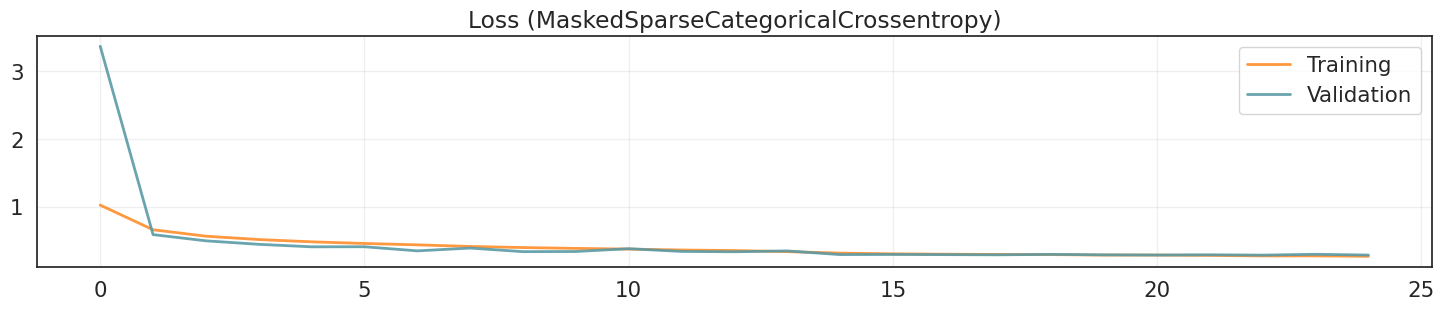

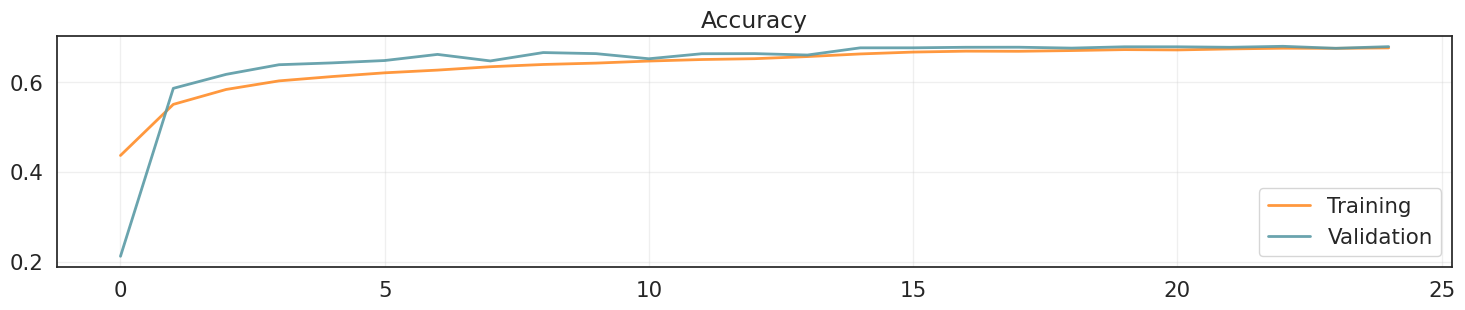

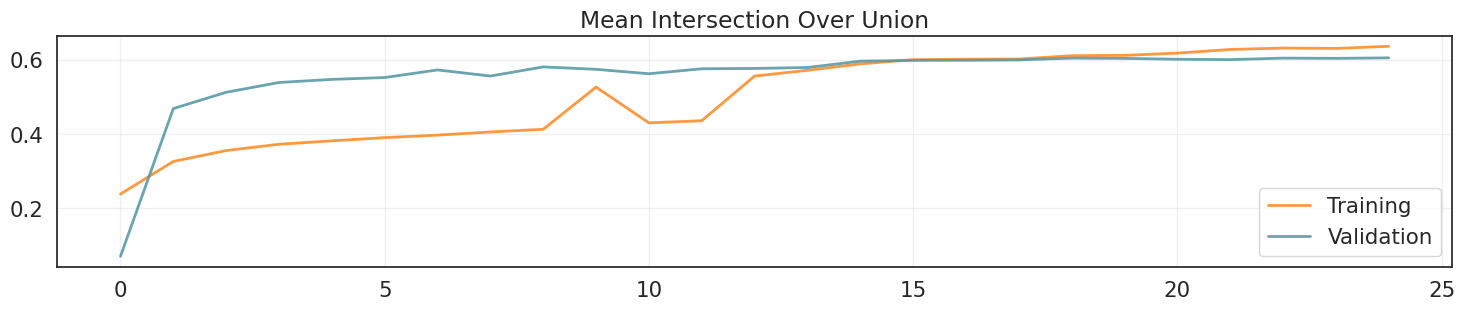

In [ ]:
training, model_filename = train(loss_fn=loss, train_dataset=train_dataset, val_dataset=val_dataset)
plot_history(training, loss)

#Model evaluation and segmentation visualization

W0000 00:00:1733933431.652736      67 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733933437.955110      69 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


Test Accuracy: 0.6794
Test Mean Intersection over Union: 0.6051


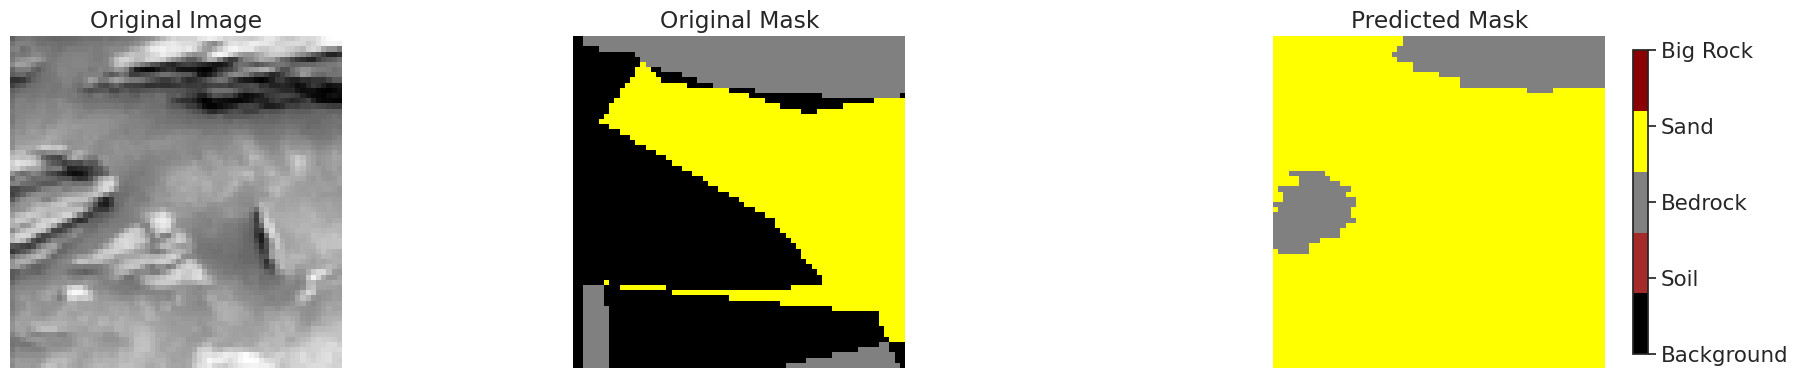

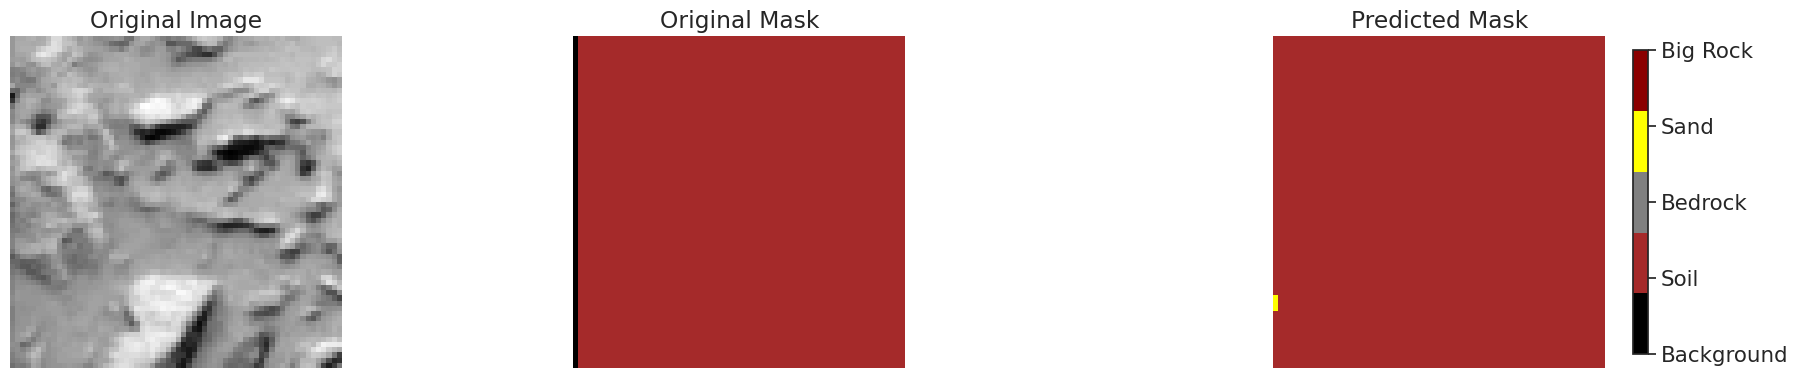

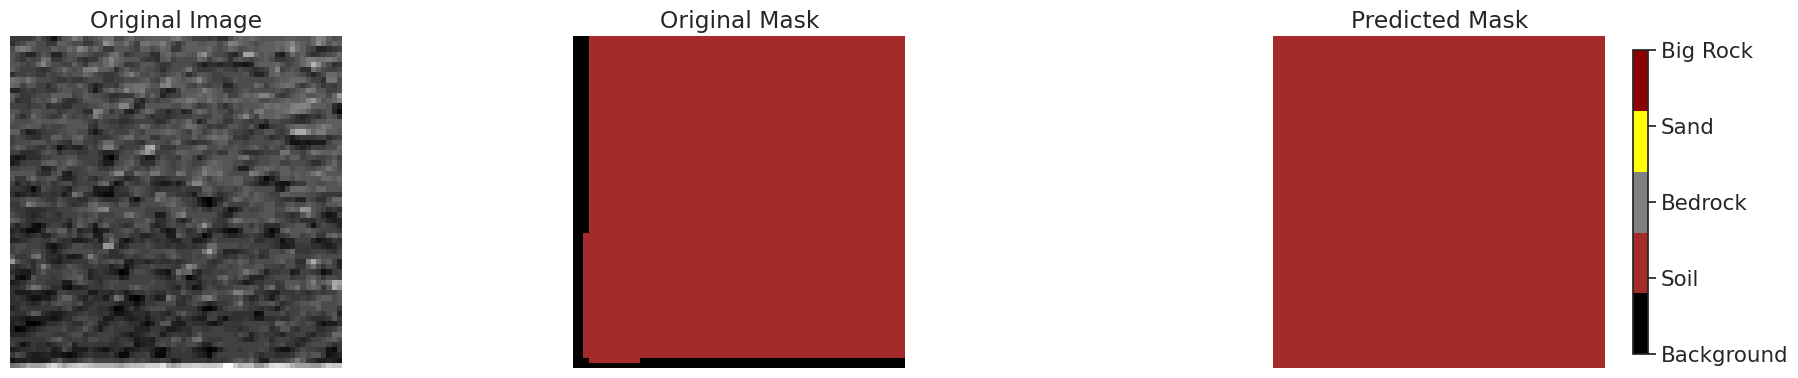

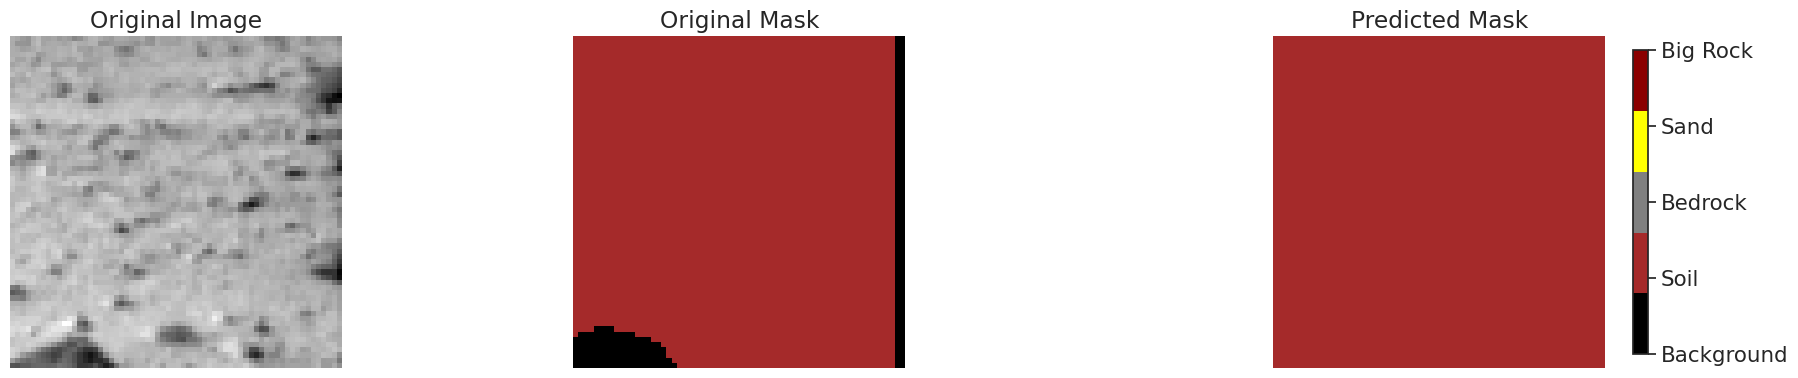

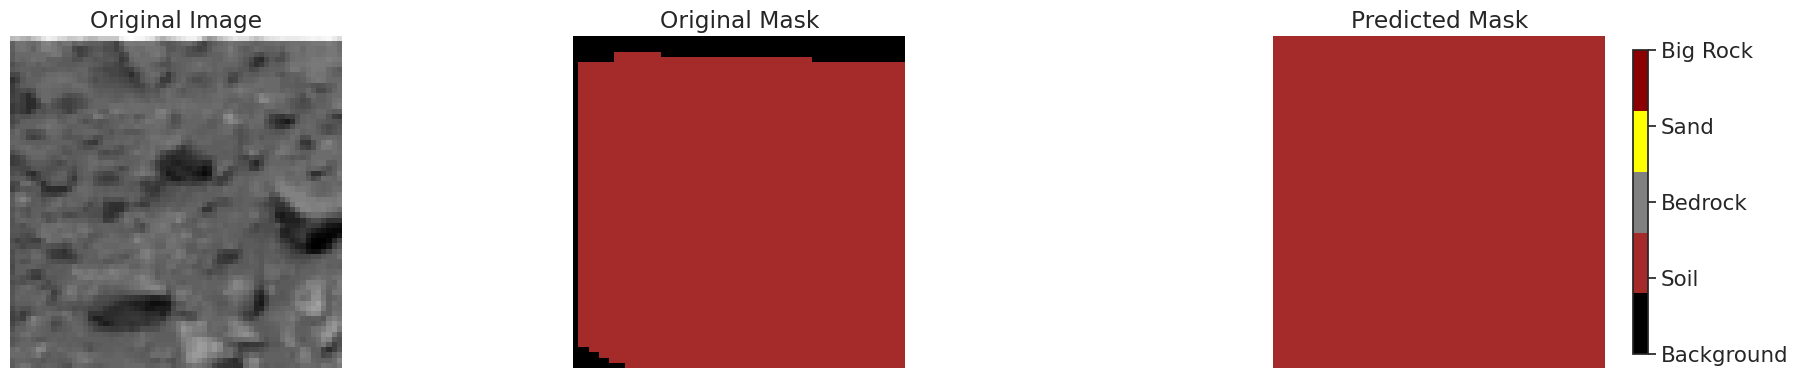

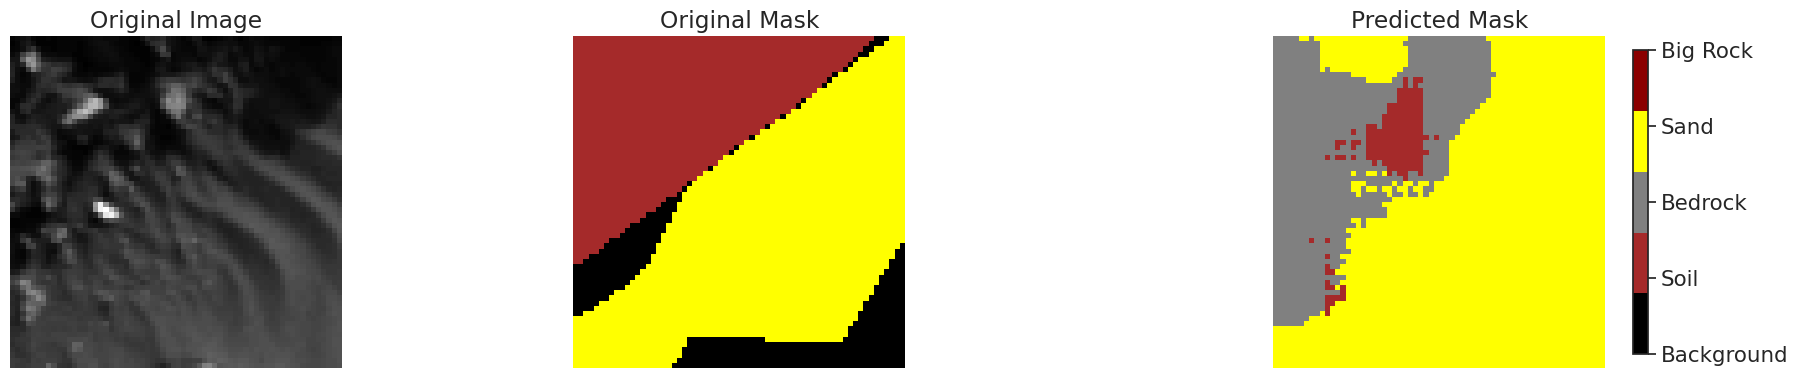

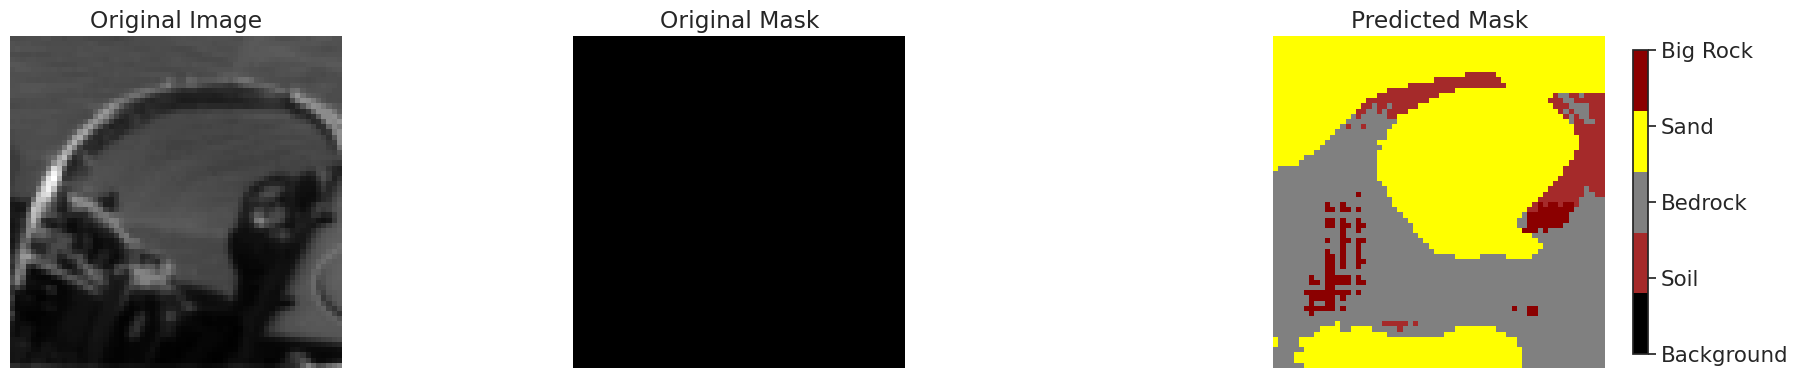

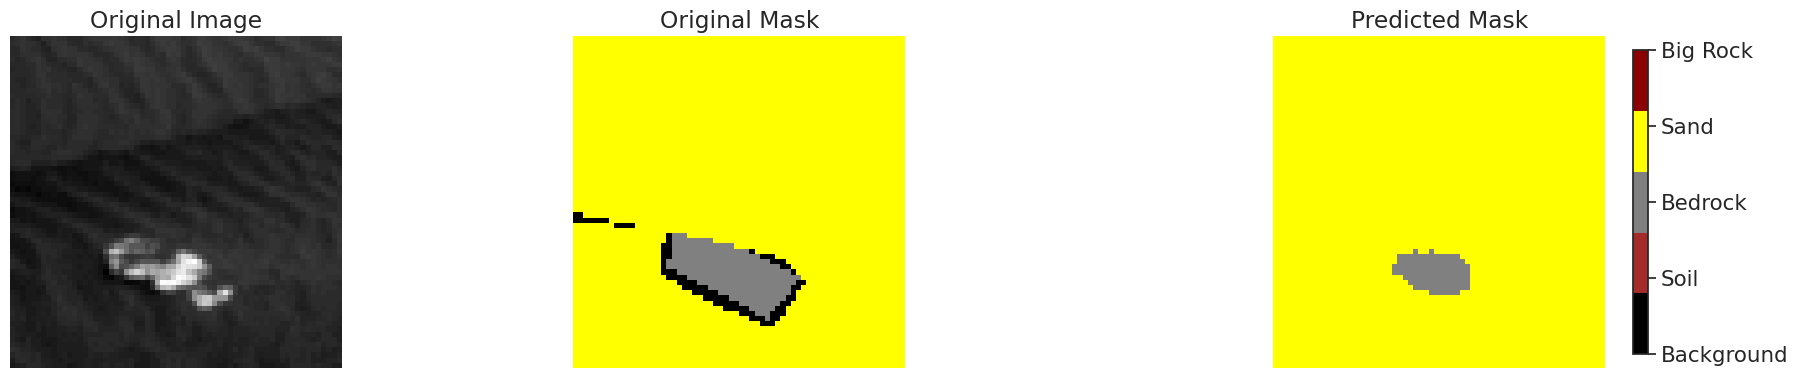

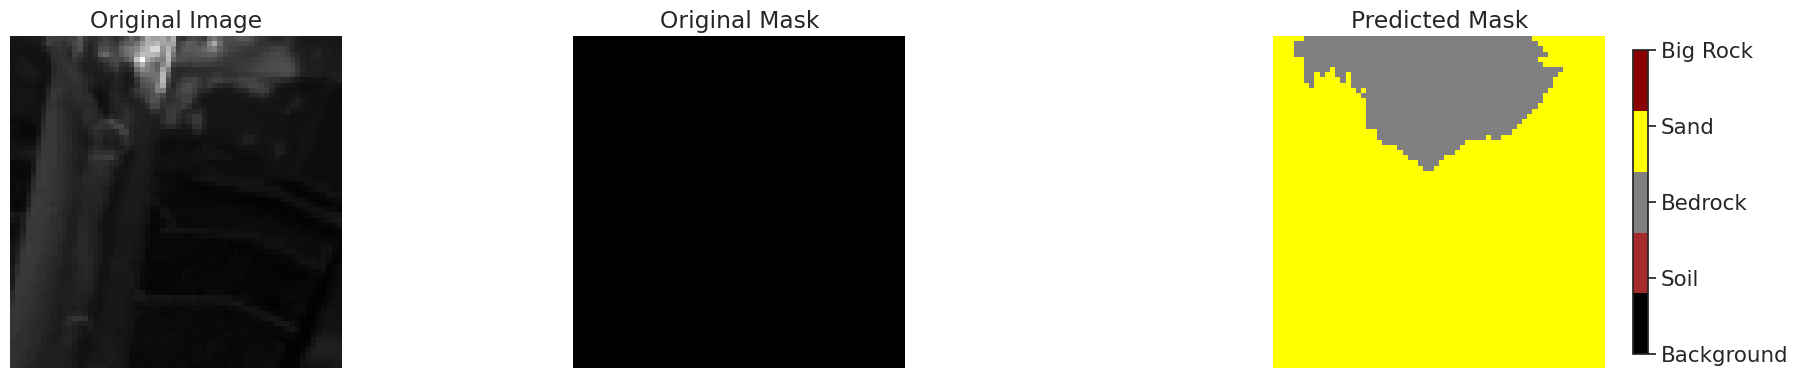

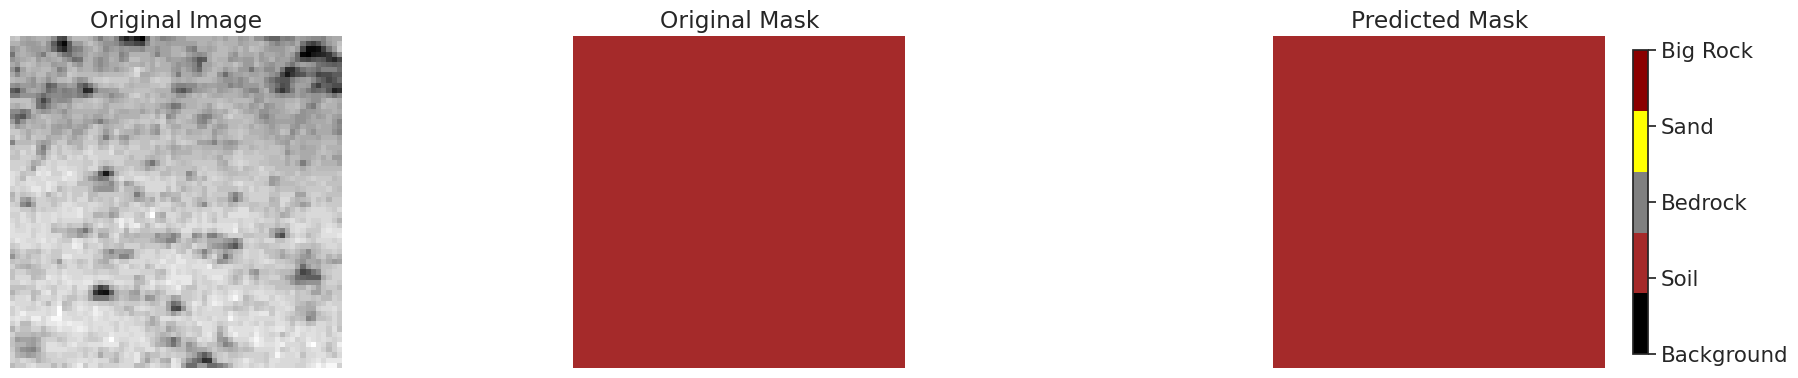

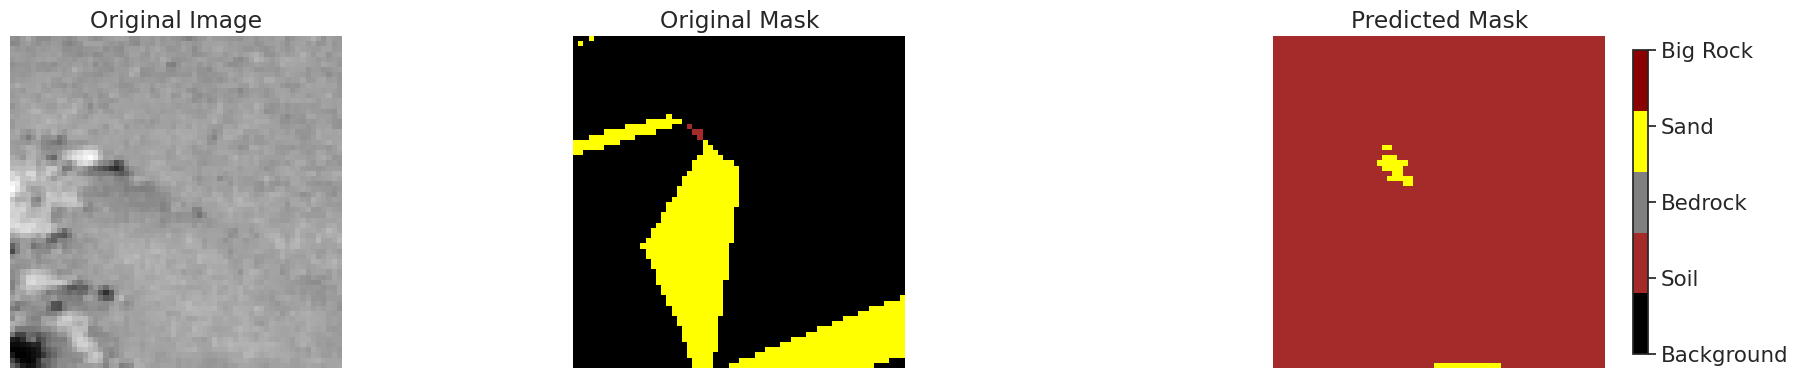

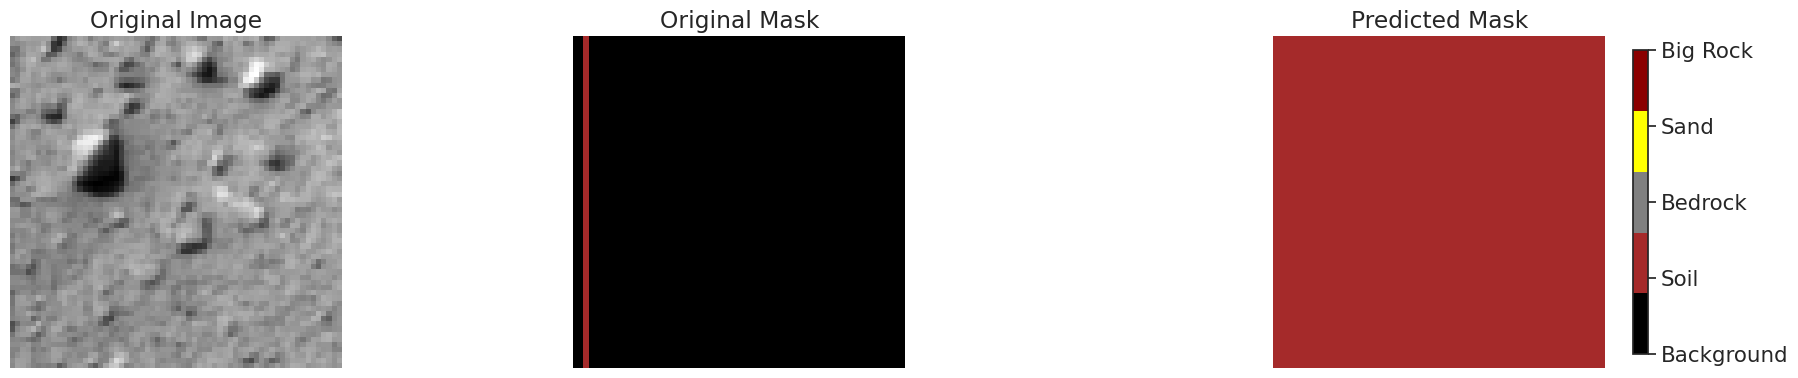

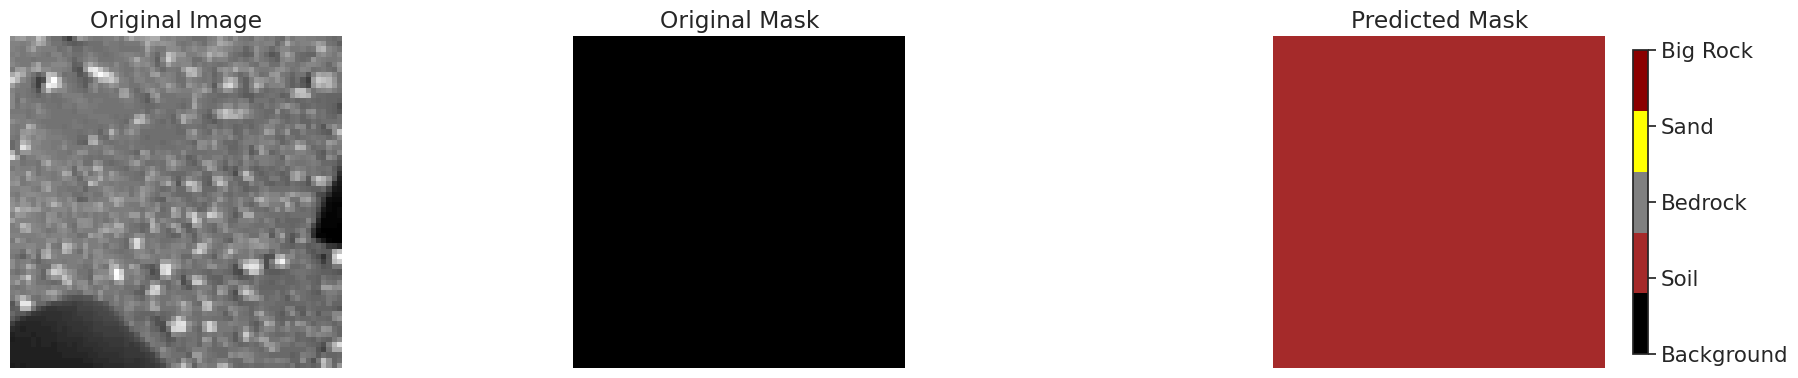

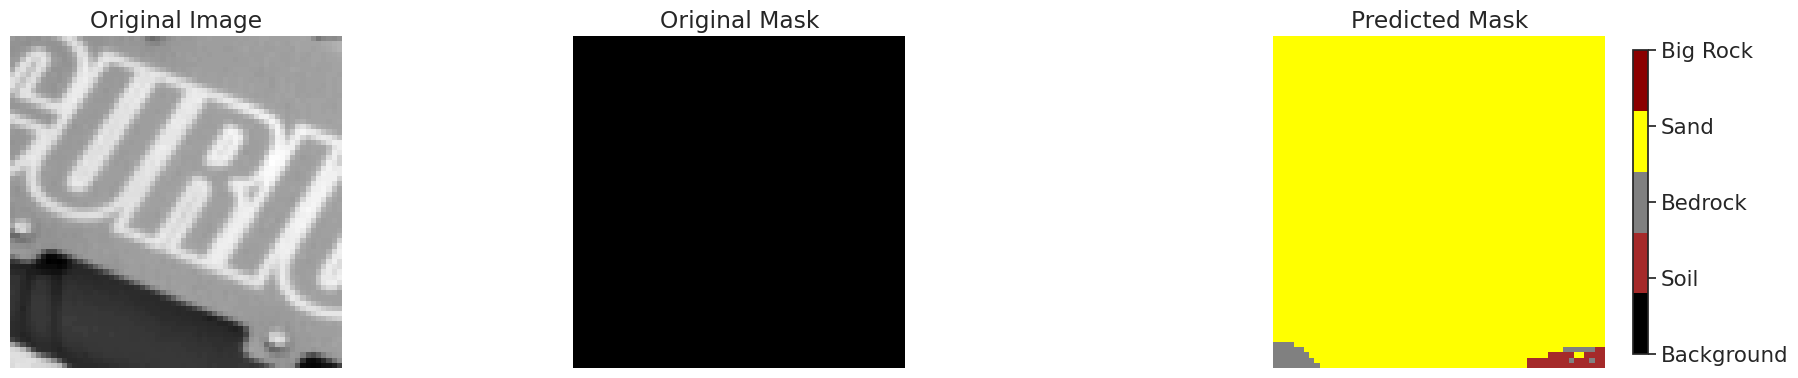

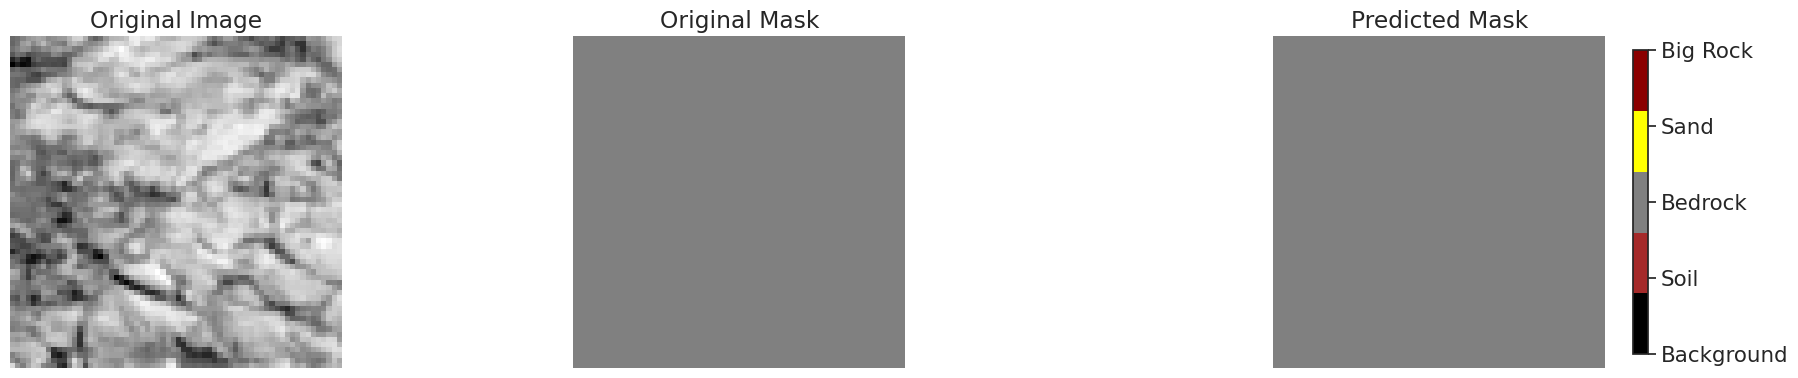

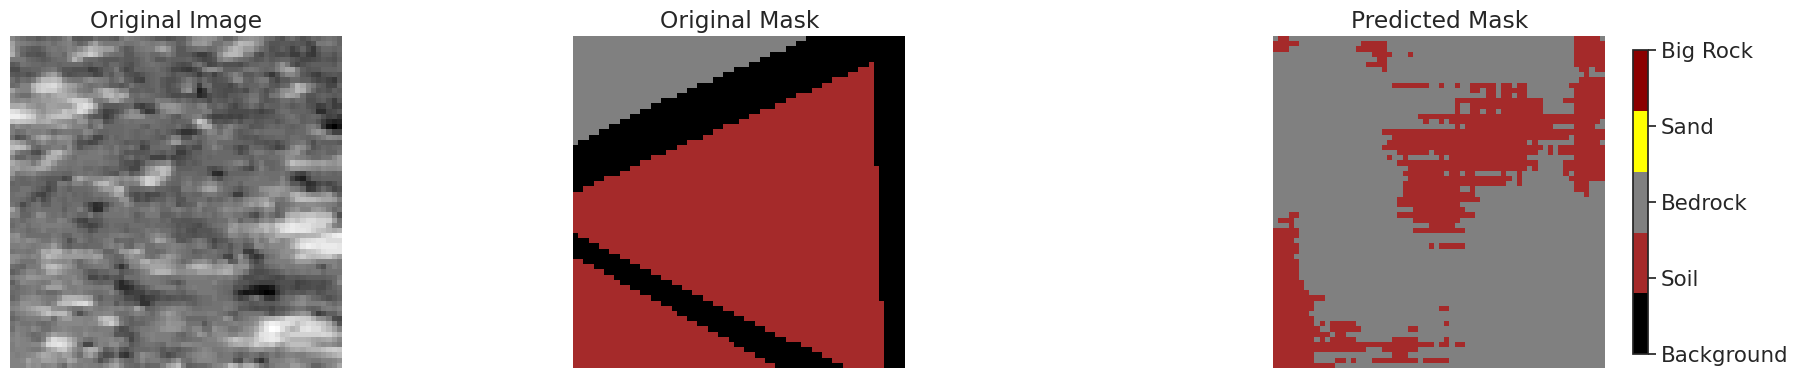

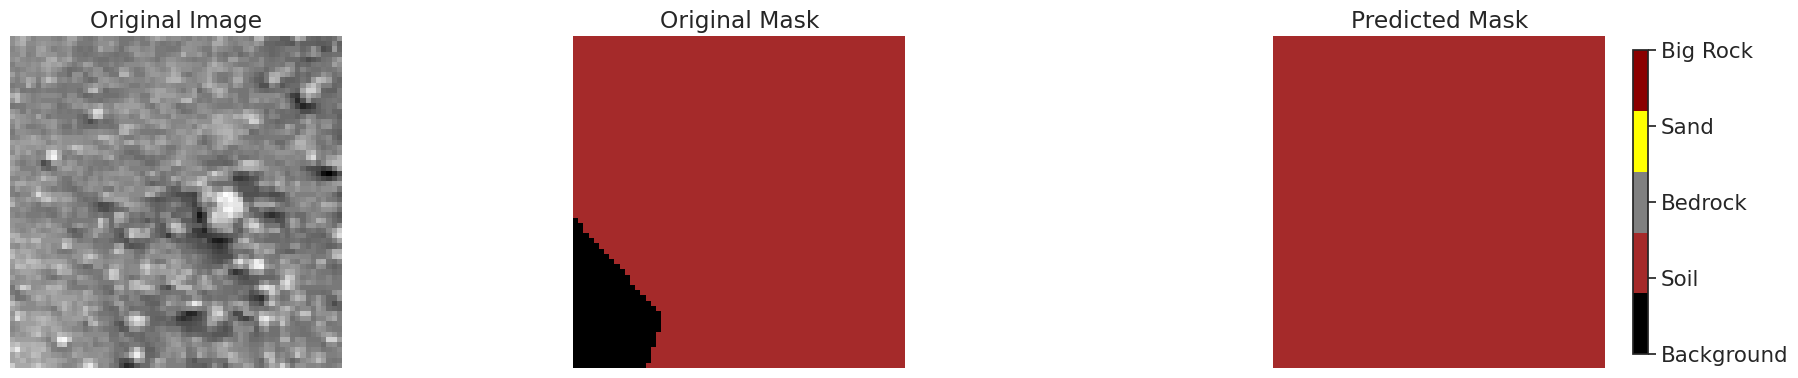

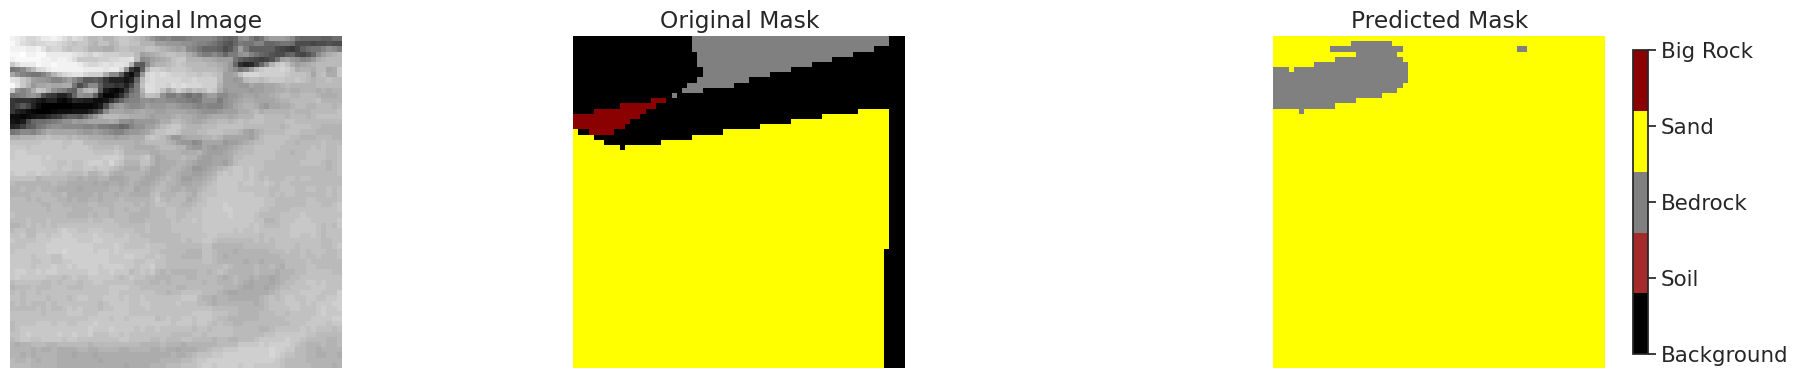

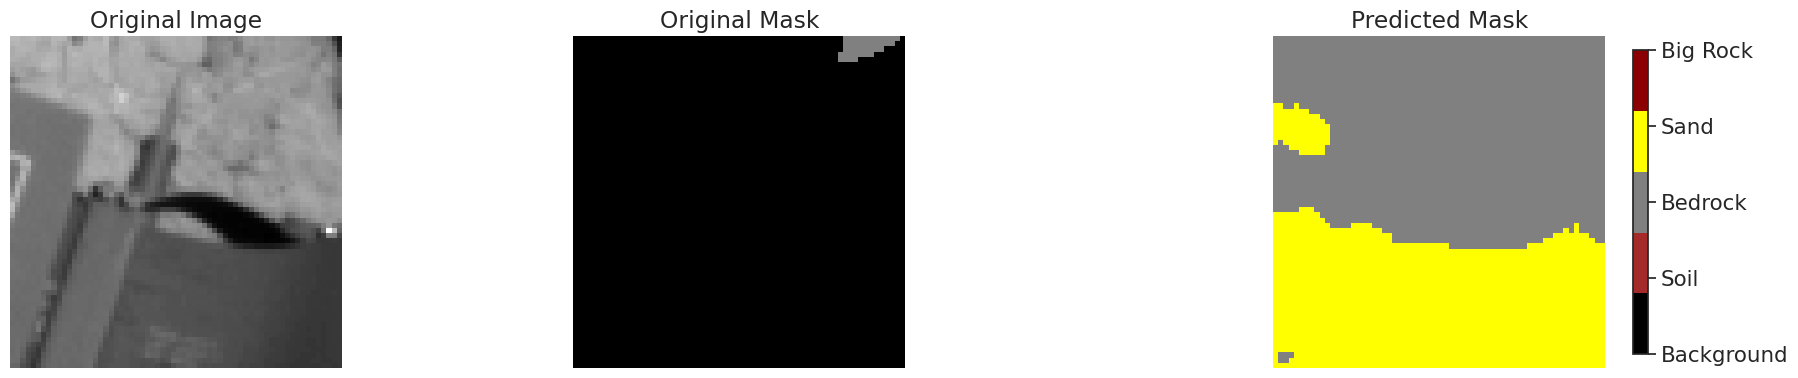

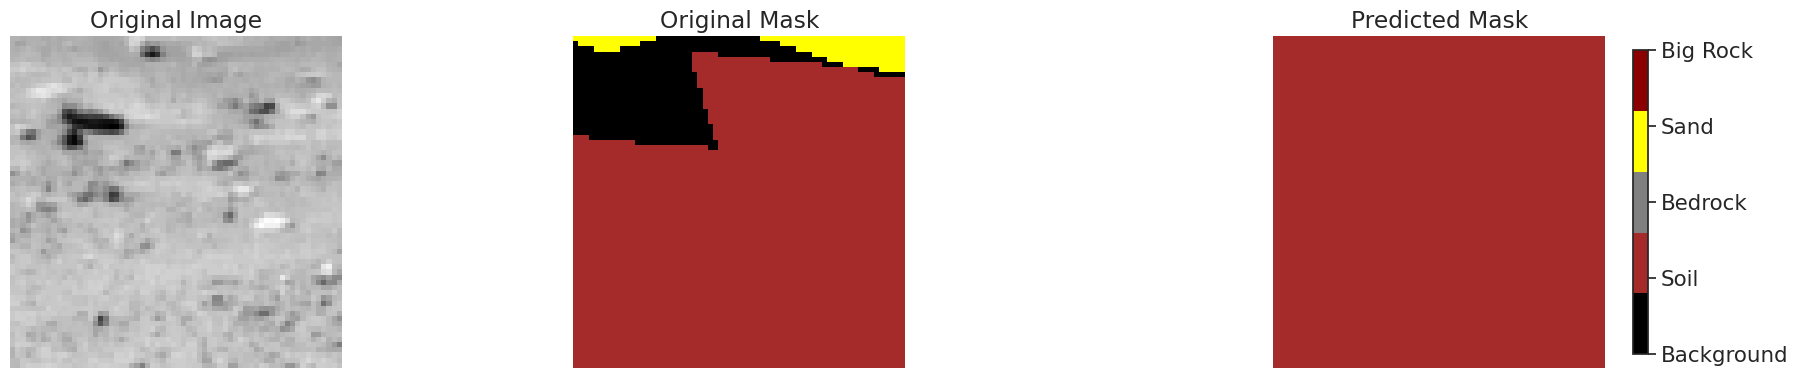

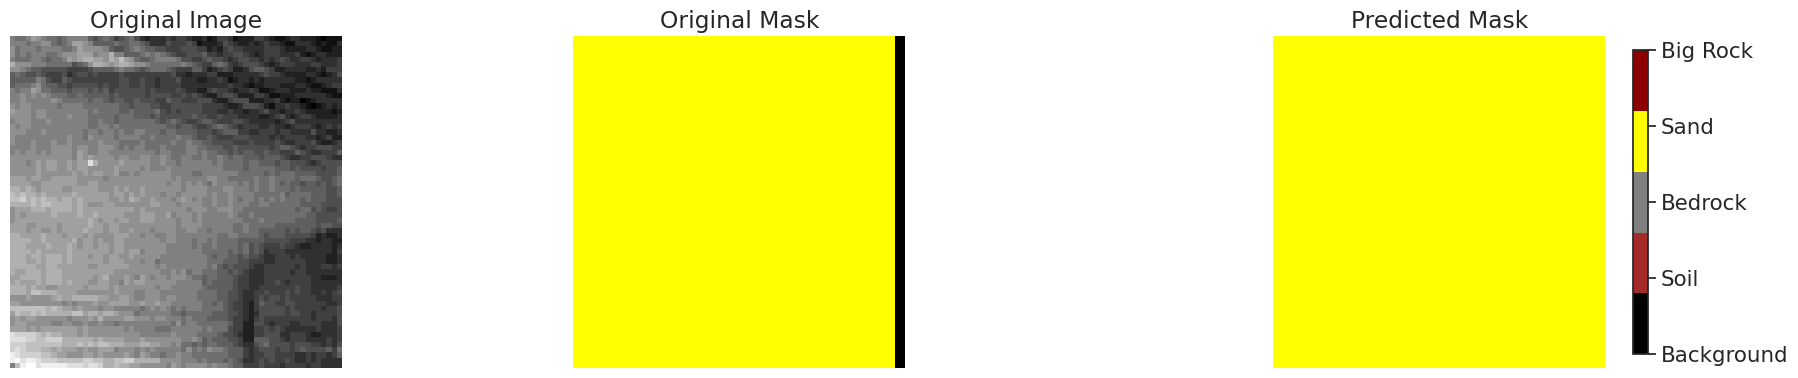

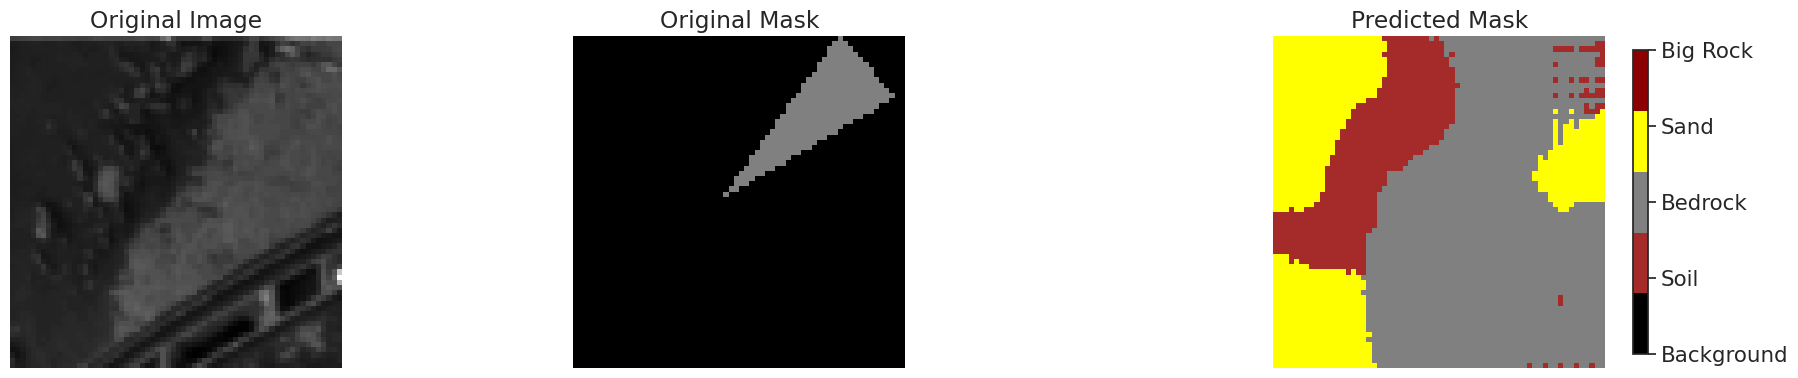

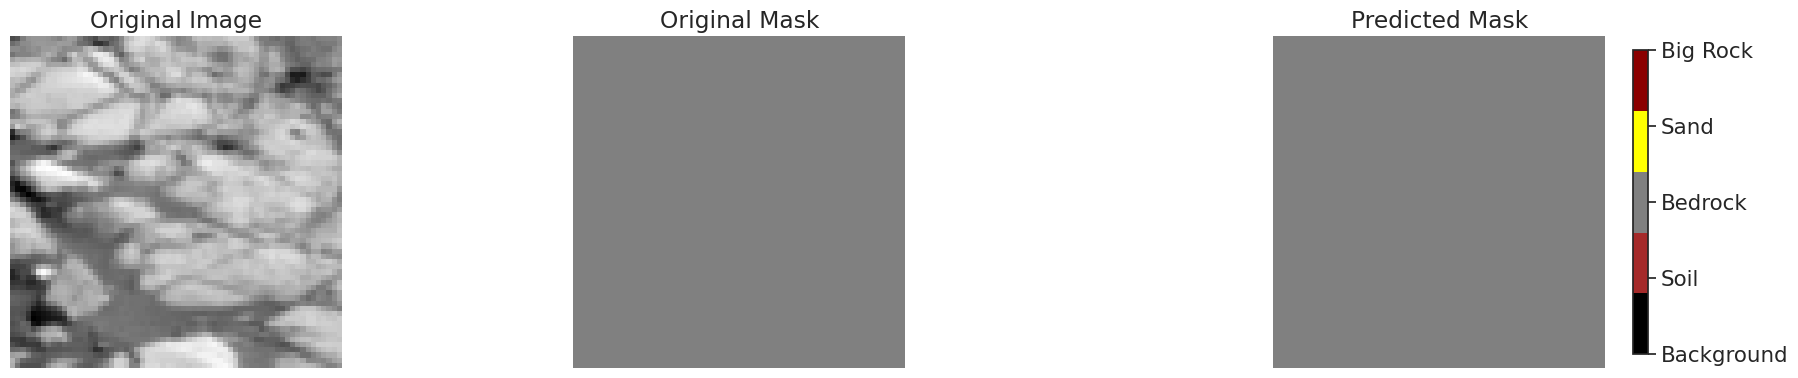

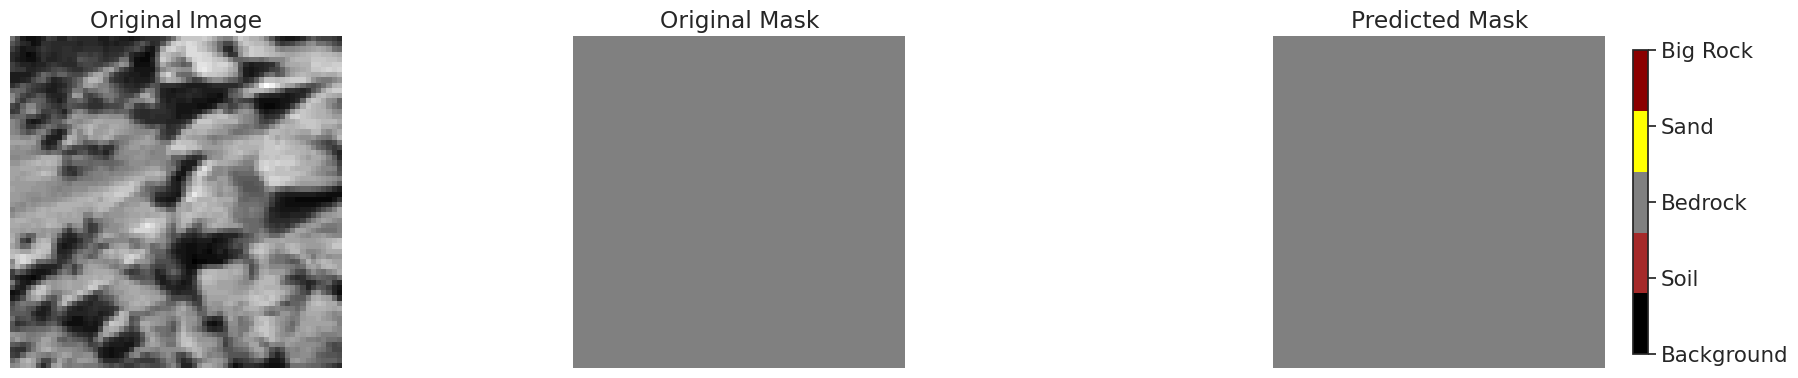

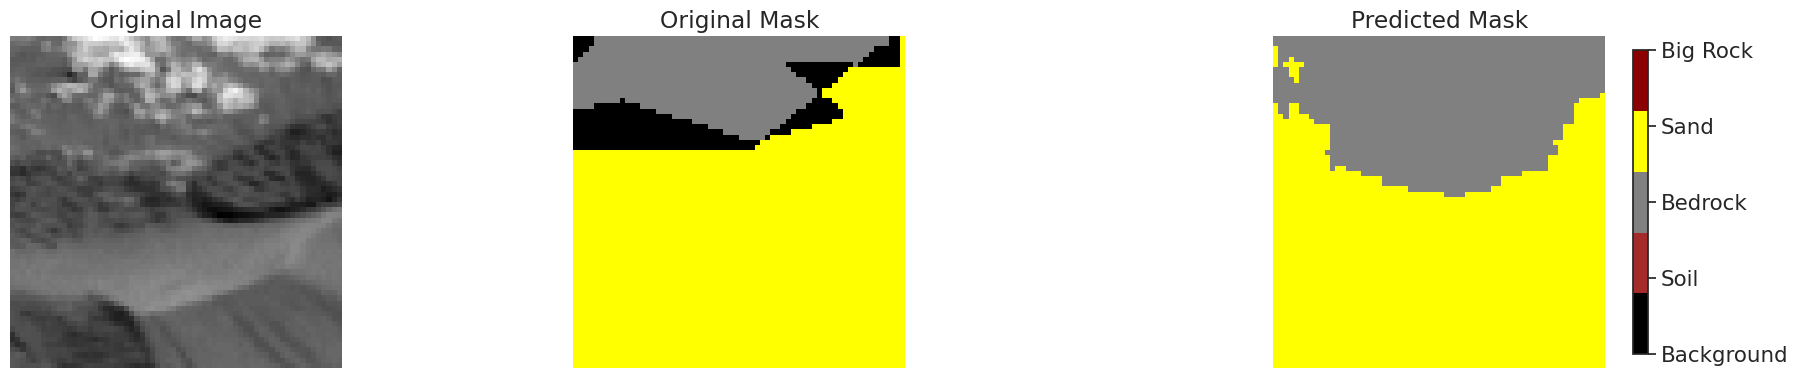

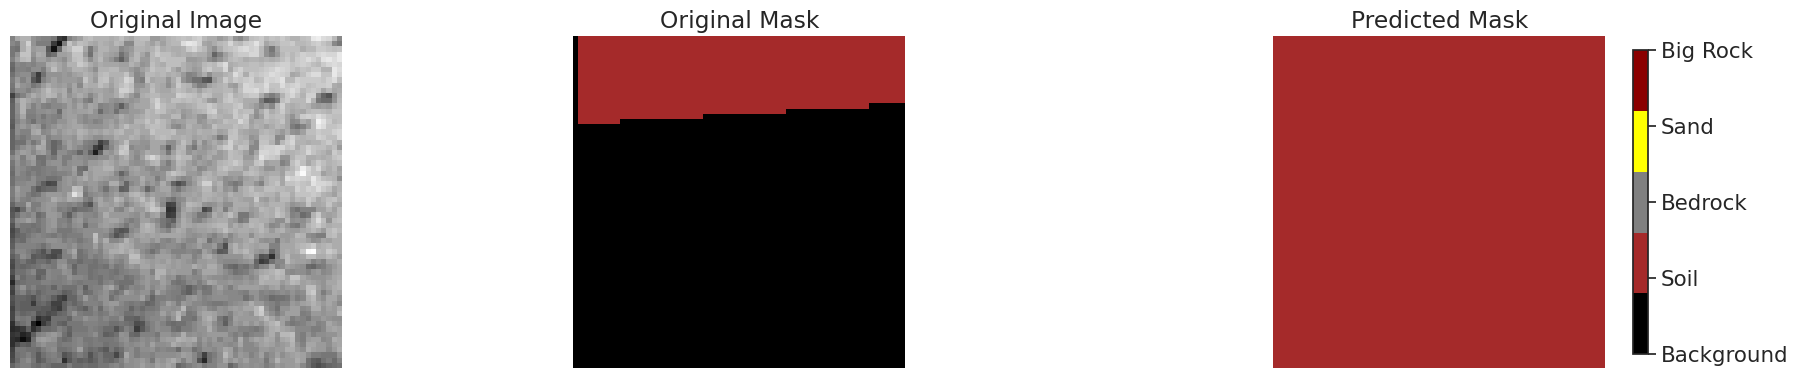

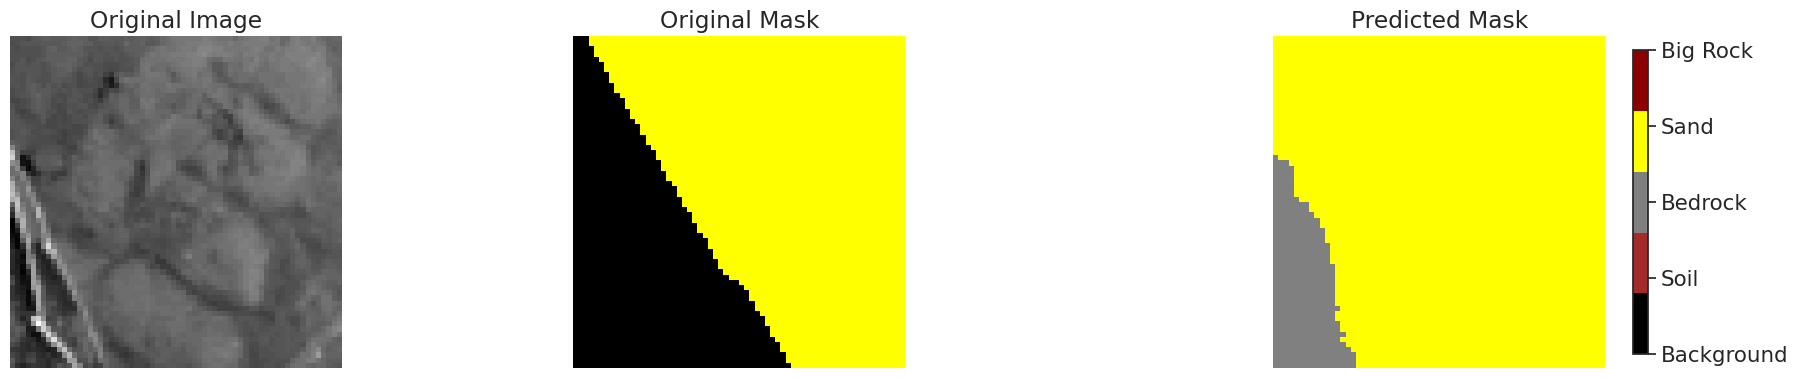

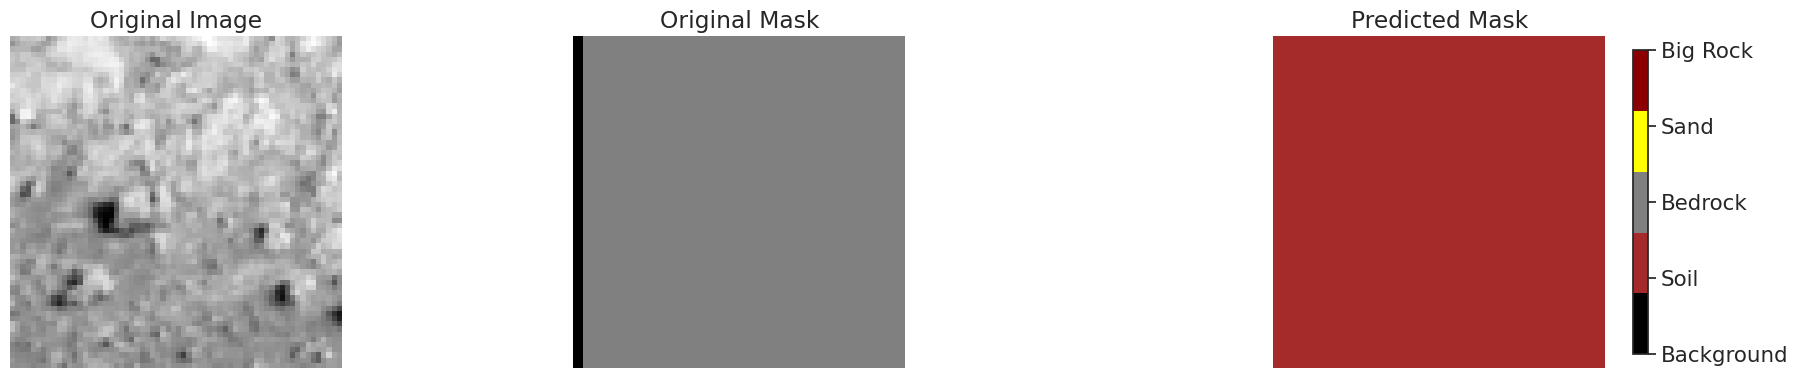

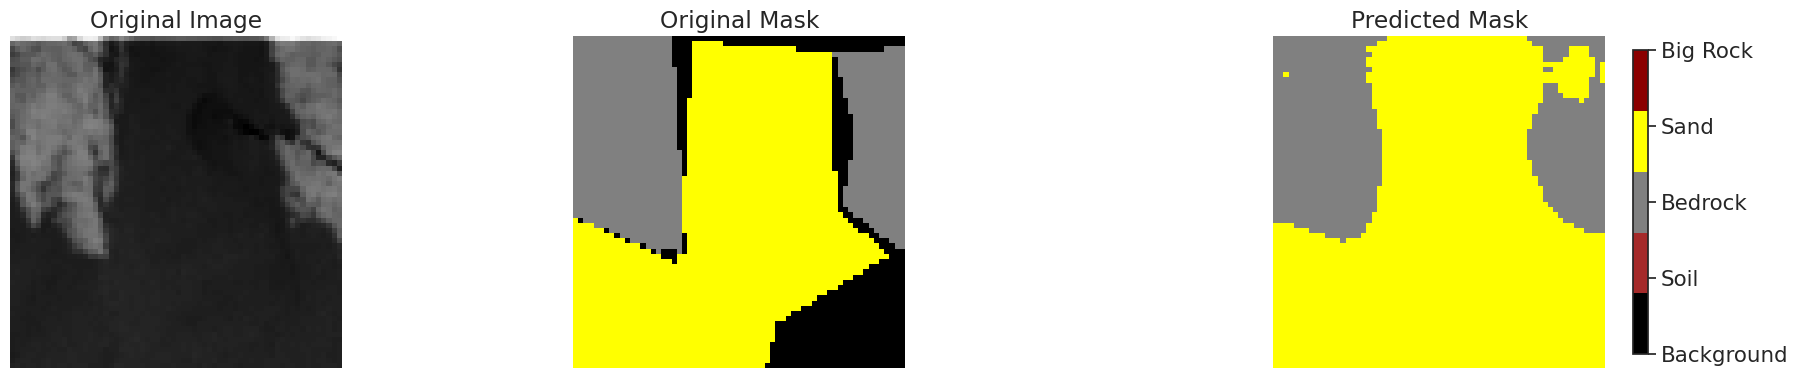

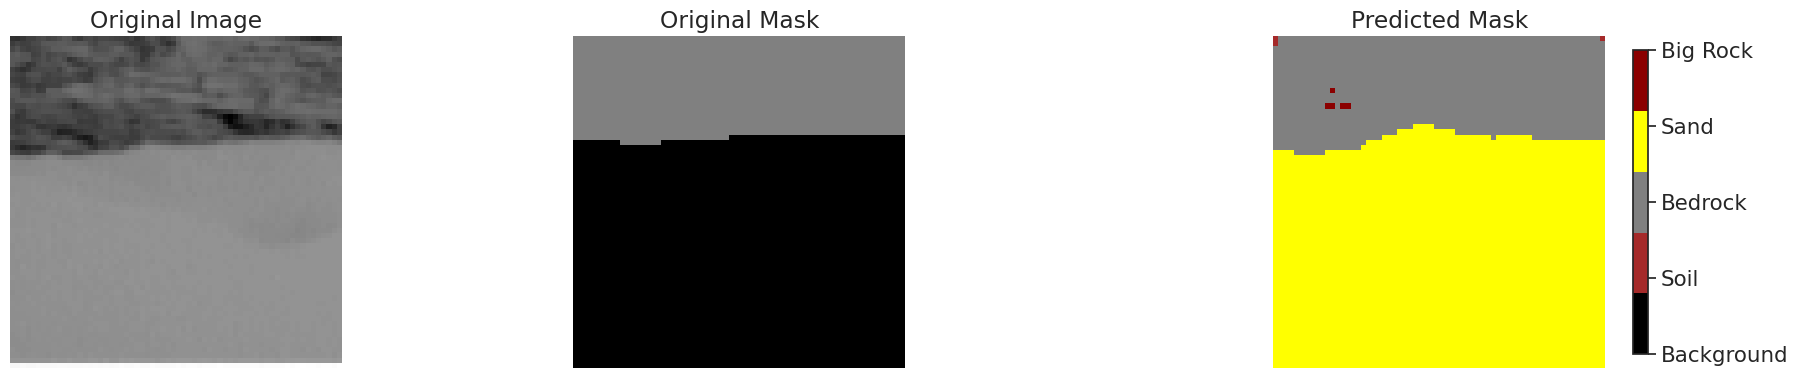

In [ ]:
# Load model
model = tfk.models.load_model(model_filename, compile=False)
model.compile()
# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=loss,
    optimizer=OPTIMIZER,
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

# Evaluate the model on the val set and print the results
val_loss, val_accuracy, val_mean_iou = model.evaluate(val_dataset, verbose=0, batch_size=10)
print(f'Val Accuracy: {round(val_accuracy, 4)}')
print(f'Val Mean Intersection over Union: {round(val_mean_iou, 4)}')

# Plot some random samples from the validation set
plot_triptychs(val_dataset, model, num_samples=30)

#Compute the predictions on the submission test set and generate a segmentations csv file

In [ ]:
#compute predictions
preds = model.predict(X_final_test)
preds = np.argmax(preds, axis=-1)

314/314 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step


In [ ]:
#to pandas dataframe
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)
